In [40]:
import pandas as pd 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [60]:
# filepath = "data/all_predictions.csv"
# combined_df = pd.read_csv(filepath)
# combined_df.shape

(85420, 8)

In [61]:
# invalid_strs = ["chat.openai.comChecking", "​\r\n\r\n\r\n···\r\nChatGPT", "!Your authentication token has expired. "]
# conditions = (combined_df["answer"].astype('str').str.contains(invalid_strs[0])) | (combined_df["answer"].astype('str').str.contains(invalid_strs[1])) | (combined_df["answer"].astype('str').str.contains(invalid_strs[2]))
# invalid_answers = combined_df[conditions]
# print(invalid_answers.shape)
# invalid_answers.to_csv("outputs/invalid_answers_1.csv", index=False)

(101, 8)


In [62]:
# # remove addtl invalid
# combined_df = combined_df[~conditions]
# combined_df.shape

(85319, 8)

In [63]:
# subset = ["answer"]
# duplicate_rows = combined_df[combined_df.duplicated(subset=subset, keep=False)]
# duplicate_rows.shape

(12008, 8)

In [36]:
# # filter for essentially the same question
# plotme = []
# xs = range(10,300, 2)

# for i in xs:
#     combined_df["q_trunc"] = combined_df["question"].str.slice(stop=i)
#     subset = ["answer","q_trunc","true_label","pred_label"]
#     duplicate_rows = combined_df[combined_df.duplicated(subset=subset, keep=False)]
#     plotme.append(duplicate_rows.shape[0])

# plt.plot(xs, plotme)

In [37]:
# combined_df["q_trunc"] = combined_df["question"].str.slice(stop=120)
# subset = ["answer","q_trunc","true_label","pred_label"]
# duplicate_rows = combined_df[combined_df.duplicated(subset=subset, keep=False)]
# duplicate_rows.shape

In [67]:
# # drop duplicate Q&As (~3k rows)
# combined_df = combined_df.drop_duplicates(subset=["answer"])
# combined_df.shape

(79278, 8)

In [68]:
# combined_df.to_csv("data/all_predictions_deduped.csv", index=False)

## Confusion Matrix

In [69]:
combined_df = pd.read_csv("data/all_predictions_deduped.csv")
combined_df.shape

(79278, 8)

In [70]:
confusion_matrix = pd.crosstab(combined_df['true_label'], combined_df['pred_label'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,Fake,Real
Actual,,
Fake,24704,1488
Real,2530,50556


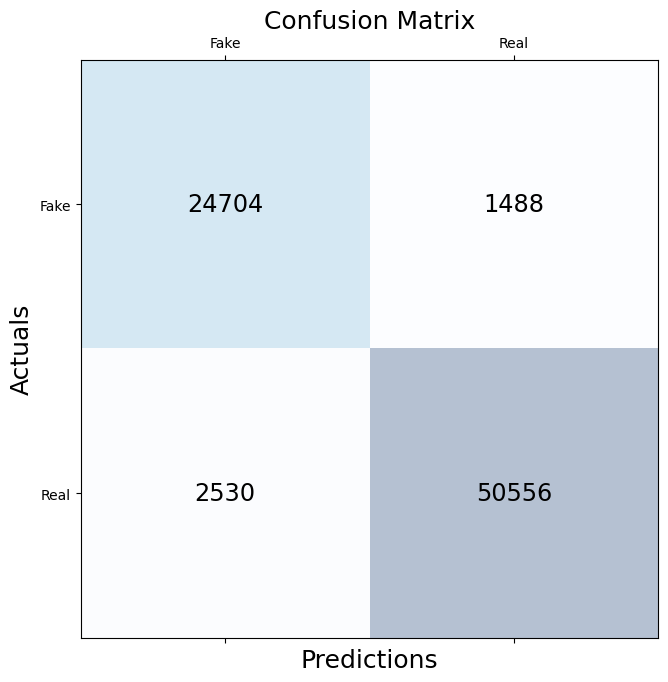

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(combined_df['true_label'], combined_df['pred_label'])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xticks(ticks=[0,1], labels=["Fake", "Real"])
plt.yticks(ticks=[0,1], labels=["Fake", "Real"])
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Accuracy

In [ ]:
# baseline accuracy
(combined_df['true_label'] == "Real").sum() / combined_df.shape[0]

0.6696183052044703

In [ ]:
# model accuracy
accuracy_score(combined_df['true_label'], combined_df['pred_label'])

0.9493175912611317

In [46]:
precision, recall, fscore, supp = precision_recall_fscore_support(combined_df['true_label'], combined_df['pred_label'], average="binary", pos_label="Real")
precision, recall, fscore, supp 

(0.9714088079317501, 0.9523414836303357, 0.9617806525254448, None)

In [13]:
misclassified_texts = combined_df[combined_df['true_label'] != combined_df['pred_label']]
misclassified_texts = misclassified_texts.sort_values(by='pred_probability', ascending=True)
print(misclassified_texts.shape)
# misclassified texts data quality checks - should not have any real-real / fake-fake
misclassified_texts.groupby(['true_label', 'pred_label']).size()

(4018, 8)


true_label  pred_label
Fake        Real          1488
Real        Fake          2530
dtype: int64

In [14]:
dupe_idxs = (misclassified_texts.groupby("answer").size() > 1).index
misclassified_texts[misclassified_texts["answer"].isin(dupe_idxs)].groupby('answer').size().reset_index().sort_values(by=0)

,answer,0
0,are the costs associated with getting a new m...,1
2670,"Sure! When we breathe in, the air goes down ou...",1
2671,"Sure! When you burn a candle, the heat from th...",1
2672,"Sure! When you shake a drink, you put all the ...",1
2673,"Sure, I can help you with that. Short selling ...",1
...,...,...
1345,I'm not sure what you're asking about when you...,1
1346,"I'm not sure what you're asking about, but it'...",1
1347,"I'm not sure what you're referring to with ""wh...",1
1334,I wrote a very long detailed write - up of the...,1


In [15]:
subset_mis = ["answer"]
misclassed_dupe_answers = misclassified_texts[misclassified_texts.duplicated(subset=subset_mis, keep=False)]
misclassed_dupe_answers

,ans_id,answer,q_id,question,true_label,source,pred_label,pred_probability


In [17]:
misclassified_texts.shape

(4018, 8)

In [18]:
misclassified_texts.to_csv("data/full_misclassified.csv", index=False)